<a href="https://colab.research.google.com/github/usef-kh/EC523-Deep-Learning-Project/blob/master/CNN%20Ensemble/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
%%capture
!git clone "https://github.com/usef-kh/EC523-Deep-Learning-Project.git"
!pip install unrar
!unrar e "EC523-Deep-Learning-Project/datasets/fer2013.rar"

##Imports

In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.models as models

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Load Dataset

In [ ]:
fer2013 = pd.read_csv('fer2013.csv') 
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

xtrain, ytrain = prepare_data(fer2013[fer2013['Usage'] == 'Training'])
xval , yval = prepare_data(fer2013[fer2013['Usage'] == 'PrivateTest'])
xtest, ytest = prepare_data(fer2013[fer2013['Usage'] == 'PublicTest'])

In [ ]:
class Fer2013(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform        
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx]).type(torch.long)
        sample = (img, label)
        
        return sample

mu, st = 0, 255
train_transform = transforms.Compose([
                    transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
                    transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=mu, std = st)
                    ])

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=mu, std = st)
                    ])

train = Fer2013(xtrain, ytrain, train_transform)
val = Fer2013(xval, yval, test_transform)
test = Fer2013(xtest, ytest, test_transform)

In [ ]:
trainloader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True, num_workers=2)

Batch Images Shape: torch.Size([100, 1, 48, 48])
Batch Labels Shape: torch.Size([100])

Neutral Surprise Disgust Neutral   Happy


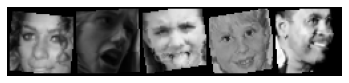

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("Batch Images Shape:", images.shape)
print("Batch Labels Shape:", labels.shape)
print()

# show 5 images
imshow(torchvision.utils.make_grid(images[:5]))
plt.axis('off')
# print labels
print(' '.join('%7s' % emotions[labels[j].item()] for j in range(5)))

## Defining Model

In [ ]:
class History:
    def __init__(self):
        self.loss_train = []
        self.loss_val = []

        self.acc_train = []
        self.acc_val = []

### Subnets

In [ ]:
class Subnet1Features(nn.Module):
    def __init__(self):
        super(Subnet1Features, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)

        self.lin1 = nn.Linear(256 * 6 * 6, 4096) 
        self.lin2 = nn.Linear(4096, 4096)
        
        self.history = History()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        x = x.view(-1, 256*6*6) 
        
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        
        return x

class Subnet1(Subnet1Features):
    def __init__(self):
        super(Subnet1, self).__init__()
        self.lin3 = nn.Linear(4096, 7)
        
        self.history = History()

    def forward(self, x):
        super(Subnet1, self).forward(x)
        x = self.lin3(x)

        return x

In [ ]:
class Subnet2Features(nn.Module):
    def __init__(self):
        super(Subnet2Features, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64,128,3,padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_2 = nn.Conv2d(256,256, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3_2 = nn.BatchNorm2d(256)
        
        self.lin1 = nn.Linear(256 * 6 * 6, 4096)
        self.lin2 = nn.Linear(4096, 4096)

        self.history = History()
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = self.pool(x)

        x = x.view(x.size(0), 256 * 6 * 6)

        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))

        return x

class Subnet2(Subnet2Features):
    def __init__(self):
        super(Subnet2, self).__init__()
        self.lin3 = nn.Linear(4096, 7)
        self.history = History()

    def forward(self, x):
        super(Subnet2, self).forward(x)
        x = self.lin3(x)

        return x

In [ ]:
class Subnet3Features(nn.Module):
    def __init__(self):
        super(Subnet3Features, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64,128,3,padding=1)
        self.conv2_2 = nn.Conv2d(128,128,3,padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_2 = nn.Conv2d(256,256, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.bn1 = nn.BatchNorm2d(num_features= 64)
        self.bn2 = nn.BatchNorm2d(num_features= 128)
        self.bn2_2 = nn.BatchNorm2d(num_features= 128)
        self.bn3 = nn.BatchNorm2d(num_features= 256)
        self.bn3_2 = nn.BatchNorm2d(num_features= 256)

        self.lin1 = nn.Linear(256 * 6 * 6, 4096)
        self.lin2 = nn.Linear(4096, 4096)
        
        self.history = History()
        
    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = self.pool(x)

        x = x.view(-1, 256*6*6)
      
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        
        return x

class Subnet3(Subnet3Features):
    def __init__(self):
        super(Subnet3, self).__init__()
        self.lin3 = nn.Linear(4096, 7)

        self.history = History()
        
    def forward(self, x):
        super(Subnet3, self).forward(x)       
        x = self.lin3(x)

        return x

In [ ]:
class reVggFeatures(nn.Module):
  def __init__(self):
    super(reVggFeatures, self).__init__()
    self.convert = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1)
    
    vgg = models.vgg19(pretrained=True).features
    vgg.to(device)
    vgg.eval()

    self.vgg = vgg 
    
    self.history = History()

  def forward(self, x):
    x = self.convert(x)

    x = self.vgg(x)
    x = x.view(-1, 512 * 1 * 1)
    
    return x

class reVgg(reVggFeatures):
  def __init__(self):
    super(reVgg, self).__init__()
    
    self.lin1= nn.Linear(512 * 1 * 1, 7)
    self.history = History()
  
  def forward(self, x):
    super(reVgg, self).forward(x) 
    x = self.lin1(x)
    
    return x

### Ensemble

In [ ]:
class Ensemble(nn.Module):
    def __init__(self, subnet1, subnet2, subnet3, vgg):
        super(Ensemble, self).__init__()
        self.sub1 = subnet1
        self.sub2 = subnet2
        self.sub3 = subnet3
        self.vgg = vgg

        self.final_lin = nn.Linear(4096*3 + 512, 7)

        self.history = History()

    def forward(self, x):
        x_1 = self.sub1(x)
        x_2 = self.sub2(x)
        x_3 = self.sub3(x)
        x_vgg = self.vgg(x)

        x_cat = torch.cat((x_1, x_2, x_3, x_vgg), dim=1)
        x = self.final_lin(x_cat)

        return x

## Building Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_layers(pretrained, model):
    pretrained = pretrained.state_dict()
    model_dict = model.state_dict()

    pretrained = {k: v for k, v in pretrained.items() if k in model_dict}
    
    # Load layers
    model_dict.update(pretrained) 
    model.load_state_dict(pretrained)

    # Freeze layers
    for name, param in model.named_parameters():
        param.requires_grad = False

In [ ]:
pretrained_1 = Subnet1()
pretrained_1.load_state_dict(torch.load('/content/drive/Shared drives/EC523 Project/CNN Ensemble/Tuned Subnets/sub1'))
pretrained_1.eval()

pretrained_2 = Subnet2()
pretrained_2.load_state_dict(torch.load('/content/drive/Shared drives/EC523 Project/CNN Ensemble/Tuned Subnets/sub2'))
pretrained_2.eval()

pretrained_3 = Subnet3()
pretrained_3.load_state_dict(torch.load('/content/drive/Shared drives/EC523 Project/CNN Ensemble/Tuned Subnets/sub3'))
pretrained_3.eval()

pretrained_vgg = reVgg()
pretrained_vgg.load_state_dict(torch.load('/content/drive/Shared drives/EC523 Project/CNN Ensemble/VGG_trainedModel'))
pretrained_vgg.eval()

subnet1 = Subnet1Features()
subnet2 = Subnet2Features()
subnet3 = Subnet3Features()
vgg = reVggFeatures()

load_layers(pretrained_1, subnet1)
load_layers(pretrained_2, subnet2)
load_layers(pretrained_3, subnet3)
load_layers(pretrained_vgg, vgg)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
ensemble = Ensemble(subnet1, subnet2, subnet3, vgg)
ensemble = ensemble.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ensemble.parameters(), lr=0.001, momentum=0.9)

## Training

In [ ]:
def train_model(net, trainloader, valloader, n_epochs=20):

    for epoch in range(n_epochs):
        
        net = net.train()
        loss_tr, correct_count, n = 0.0, 0.0, 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # calculate performance metrics
            loss_tr += loss.item()
            
            _, preds = torch.max(outputs.data, 1)
            correct_count += (preds == labels).sum().item()
            n += labels.size(0)
            
        # Save train and validation performance metrics 
        acc_tr = 100 * correct_count / n
        loss_tr = loss_tr / n

        acc_v, loss_v = test_model(net, valloader)

        net.history.loss_train.append(loss_tr)
        net.history.loss_val.append(loss_v)

        net.history.acc_train.append(acc_tr)
        net.history.acc_val.append(acc_v)
        
        print('Epoch %2d' % (epoch + 1), 'Train Accuracy: %2.2f %%' % (acc_tr), 'Val Accuracy: %2.2f %%' % (acc_v), sep='\t\t')

In [ ]:
def test_model(net, dataloader):
    
    net = net.eval()

    loss, correct_count, n_sampels = 0.0, 0.0, 0.0
    for data in dataloader:

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)

        loss += criterion(outputs, labels).item()

        _, preds = torch.max(outputs.data, 1)
        correct_count += (preds == labels).sum().item()
        n_sampels += labels.size(0)
    
    acc = 100 * correct_count / n_sampels
    loss = loss / n_sampels
    
    return acc, loss

In [ ]:
def plot_metrics(net):
    plt.figure()
    plt.plot(net.history.acc_train, 'g', label='Training Acc')
    plt.plot(net.history.acc_val, 'b', label='Validation Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(net.history.loss_train, 'g', label='Training Loss')
    plt.plot(net.history.loss_val, 'b', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    print('Training Accuracy: %2.2f %%' % (max(net.history.acc_train)))
    print('Validation Accuracy: %2.2f %%' % (max(net.history.acc_val)))
    print()

    acc, loss = test_model(net, testloader)    
    print('Test Accuracy: %2.2f %%' % (acc))
    print('Average Test Loss: %2.4f' % (loss))

In [ ]:
train_model(ensemble, trainloader, valloader, n_epochs=10)

## Evaluation

Ensemble


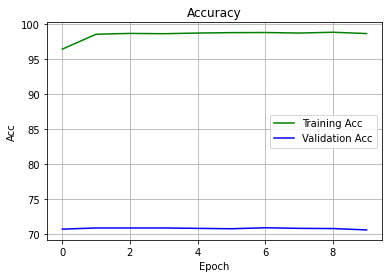

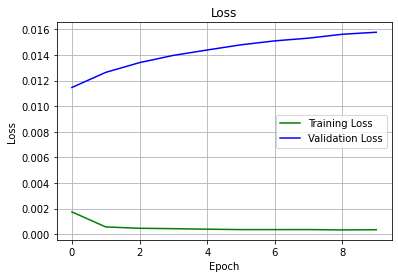

Training Accuracy: 98.85 %
Validation Accuracy: 70.91 %

Test Accuracy: 69.99 %
Average Test Loss: 0.0168


In [ ]:
print("Ensemble")
plot_metrics(ensemble)

##Save Model

In [ ]:
path = 'ensemble'
torch.save(ensemble.state_dict(), path)